
# StrategySV Optimization

Optimizing the Strategy Parameters for Algo-Strategy Forex.

Here's a quick TOC:

1. [Importing Forex Data](#importing-forex-data)
1. [Processing Data](#processing-data)
1. [Analyzing Parameters](#analyzing-parameters)
1. [Preparing Backtests](#preparing-backtests)
1. [Trading Assumptions](#trading-assumptions)
1. [Running Backtests](#running-backtets)
1. [Analyzing Backtest Results](#analyzing-backtest-results)
1. [Running Papertests](#running-papertests)
1. [Analyzing Papertest Results](#analyzing-papertest-results)
1. [Plotting Optimized Results](#plotting-optimized-results)

## Importing Forex Data


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forex_symbol = "AUDUSD"

forex_df = pd.read_csv('../../data/gen/{}_Daily_df.csv'.format(forex_symbol),
                       parse_dates=True,
                       index_col=0)
# Strip whitespace from column names
forex_df.columns = forex_df.columns.str.strip()
# Print
forex_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change
4998,2001-05-15,0.5193,0.5212,0.5150,0.5206,0.5193,0.002503,25.033699
4997,2001-05-16,0.5209,0.5240,0.5182,0.5233,0.5206,0.005186,51.863235
4996,2001-05-17,0.5230,0.5293,0.5220,0.5279,0.5233,0.008790,87.903688
4995,2001-05-18,0.5274,0.5300,0.5238,0.5291,0.5279,0.002273,22.731578
4994,2001-05-21,0.5295,0.5320,0.5266,0.5270,0.5291,-0.003969,-39.690040



## Processing Data

In order to run StrategySV, we need to calculate `slope` and `velocity` data.


In [3]:

extra_df = forex_df.copy()
extra_df['slope'] = pd.Series(np.gradient(extra_df.close), extra_df.index, name='slope')
extra_df['velocity'] = pd.Series(np.gradient(extra_df.slope), extra_df.index, name='velocity')
# Print
extra_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change,slope,velocity
4998,2001-05-15,0.5193,0.5212,0.5150,0.5206,0.5193,0.002503,25.033699,0.00270,0.000950
4997,2001-05-16,0.5209,0.5240,0.5182,0.5233,0.5206,0.005186,51.863235,0.00365,0.000100
4996,2001-05-17,0.5230,0.5293,0.5220,0.5279,0.5233,0.008790,87.903688,0.00290,-0.002050
4995,2001-05-18,0.5274,0.5300,0.5238,0.5291,0.5279,0.002273,22.731578,-0.00045,-0.002675
4994,2001-05-21,0.5295,0.5320,0.5266,0.5270,0.5291,-0.003969,-39.690040,-0.00245,-0.002150



## Analyzing Parameters

To determine sensible slop & velocity range to run backtests on, slope & velocity needs to be analysed.


DescribeResult(nobs=4999, minmax=(-0.03420000000000001, 0.030999999999999972), mean=3.285657131426288e-05, variance=1.7788737656695007e-05, skewness=-0.5104675567834824, kurtosis=5.829837390012925)

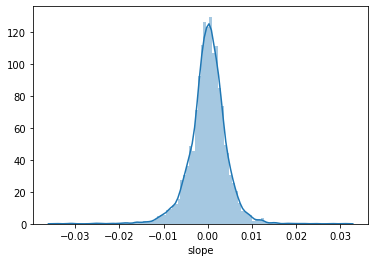

In [7]:

import seaborn as sns
from scipy import stats

sns.distplot(extra_df['slope'],
             bins=100,
             label="Daily Slope Change")
stats.describe(extra_df.slope)


DescribeResult(nobs=4999, minmax=(-0.01695000000000002, 0.03259999999999999), mean=-6.401280256051227e-07, variance=9.122003891874816e-06, skewness=0.37360918049437514, kurtosis=7.101944865931612)

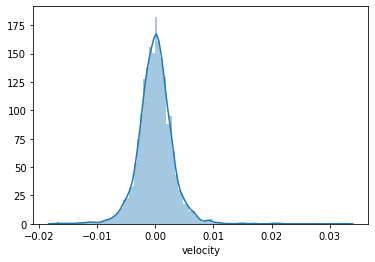

In [8]:

sns.distplot(extra_df['velocity'],
             bins=100,
             label="Daily Velocity Change")
stats.describe(extra_df.velocity)



## Preparing Backtests

Now we understand `slope` and `velocity` parameters, let's prepare parameters for backtesting.


In [9]:

import itertools

buy_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
buy_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
close_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
close_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
sell_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
sell_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)

task_list = list(itertools.product(
    buy_slope_threshold_list, 
    buy_velocity_threshold_list, 
    close_slope_threshold_list, 
    close_velocity_threshold_list, 
    sell_slope_threshold_list, 
    sell_velocity_threshold_list
))
print("Backtest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(task_list), round(len(task_list)/(200*60), 2)))


Backtest Params Ready, 15625 tasks to run. Will take about 1.3 minutes to complete.



## Trading Assumptions

Forex is usually traded in **lots**, with **leverage**. 

To understand Forex Trading, here's a quick [Forex 101](./forex-math.md).   

Before we start the backtests, let's establish some assumptions.


In [10]:

lots = 1 # Trading Size 
leverage = 400 # 400 Leverage
margin_interest = 0.1 # 10% Margin Interest
pip_cost = 0.8 # Transaction Cost 0.8 pip
stop_loss = 2.0 # Stop Loss at 2.0 of standard deviation (so 5%)
one_trade_week = 6 # 6 Trade days a week for Forex
one_trade_month = one_trade_week * 4
two_trade_month = one_trade_month * 2
three_trade_month = one_trade_month * 3
half_trade_year = three_trade_month * 2
one_trade_year = half_trade_year * 2



## Running Backtests


In [11]:

import concurrent.futures
from concurrent.futures.process import ProcessPoolExecutor
from datetime import datetime
from tqdm import tqdm

backtest_df = forex_df[:-one_trade_year] # We use all available data until 2 years ago
    
# Defining a DataFrame to handle results
backtest_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

def single_test(data_df, 
                t_lots,
                t_leverage,
                t_pip_cost,
                buy_slope_threshold, 
                buy_velocity_threshold, 
                close_slope_threshold, 
                close_velocity_threshold, 
                sell_slope_threshold, 
                sell_velocity_threshold):
            
        """
        Firstly, add `slope` and `velocity` columns to DataFrame
        """
        data_df['profit'] = 0
        data_df['slope'] = pd.Series(np.gradient(data_df.pre_close), data_df.index, name='slope') # Find the slope of yesterday, aka. pre_close
        data_df['velocity'] = pd.Series(np.gradient(data_df.slope), data_df.index, name='velocity')
        
        """
        Secondly, Closing
        """
        data_df['position'] = "CLOSE"
        
        """
        Thirdly, Buying
        """
        long_mask = (data_df.slope > buy_slope_threshold) & (data_df.velocity > buy_velocity_threshold)
        long_close = (data_df.slope < -close_slope_threshold) & (data_df.velocity < -close_velocity_threshold)
        data_df.loc[long_mask, 'position'] = "LONG"
        data_df.loc[long_mask, 'profit'] = (data_df.loc[long_mask, 'pip_change'] - t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
        
        """
        Finally, Selling
        """
        short_mask = (data_df.slope < sell_slope_threshold) & (data_df.velocity < sell_velocity_threshold)
        short_close = (data_df.slope > close_slope_threshold) & (data_df.velocity > close_velocity_threshold)
        data_df.loc[short_mask, 'position'] = "SHORT"
        data_df.loc[short_mask, 'profit'] = -(data_df.loc[short_mask, 'pip_change'] + t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
    
        test_result = [buy_slope_threshold, 
                       buy_velocity_threshold, 
                       close_slope_threshold, 
                       close_velocity_threshold, 
                       sell_slope_threshold, 
                       sell_velocity_threshold, 
                       data_df.profit.sum() / (lots * 100000 / t_leverage)]
        return test_result

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    backtest_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in task_list]
    print("Running {} tasks".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        backtest_result = backtest_result.append(pd.Series(result_row, index=backtest_result.columns), ignore_index=True)

    print("Finished {} tasks in {}".format(len(task_list), datetime.now() - start_time))


15.6ktests [01:23, 187tests/s]


Running 15625 tasks
Finished 15625 tasks in 0:01:24.335513



## Analyzing Backtest Results


DescribeResult(nobs=15625, minmax=(2025.579599044288, 7561.22884579953), mean=4993.410196952943, variance=1204945.9689914037, skewness=0.012934342640130546, kurtosis=-0.5004351582082385)


,Unnamed: 0,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
0,392,-0.004185,-0.003021,0.000876,-0.003021,0.000876,0.001812,7561.228846
18,419,-0.004185,-0.003021,0.000876,-0.001813,0.000876,0.001812,7561.228846
13,219,-0.004185,-0.003021,-0.002498,0.000603,0.000876,0.001812,7561.228846
10,293,-0.004185,-0.003021,-0.000811,-0.001813,0.000876,0.001812,7561.228846
9,570,-0.004185,-0.003021,0.002563,-0.000605,0.000876,0.001812,7561.228846


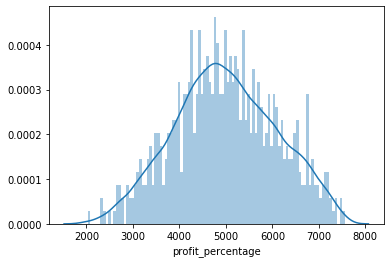

In [23]:
        
backtest_result = backtest_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
backtest_result.to_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

sns.distplot(backtest_result['profit_percentage'],
             bins=100,
             label="Backtest Results")
print(stats.describe(backtest_result.profit_percentage))

backtest_result.head()



## Running Papertests

Now we have the optimized parameters, let's run the papertests (forwardtests).


In [15]:

backtest_result = pd.read_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

paper_df = forex_df[-one_trade_year:] # We use all available data until year ago
paper_params = backtest_result.iloc[:1000] # We will papertest the profit generated by best 1,000 sets of parameters

paper_list = list(zip(paper_params.buy_slope_threshold, 
                     paper_params.buy_velocity_threshold,
                     paper_params.close_slope_threshold, 
                     paper_params.close_velocity_threshold,
                     paper_params.sell_slope_threshold, 
                     paper_params.sell_velocity_threshold,))


print("Papertest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(paper_list), round(len(paper_list)/(200*60), 2)))
    

Papertest Params Ready, 1000 tasks to run. Will take about 0.08 minutes to complete.


In [16]:
# Defining a DataFrame to handle results
paper_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    paper_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in paper_list]
    print("Running {} tests".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        paper_result = paper_result.append(pd.Series(result_row, index=paper_result.columns), ignore_index=True)

    print("Finished {} tests in {}".format(len(paper_list), datetime.now() - start_time))


1.00ktests [00:04, 241tests/s]


Running 1000 tests
Finished 1000 tests in 0:00:04.264489



## Analyzing Papertest Results


DescribeResult(nobs=1000, minmax=(250.55799736643647, 316.9621729813505), mean=278.78079283245233, variance=294.3366252053874, skewness=0.36650930080708893, kurtosis=-0.8966457275458786)


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
199,-0.002498,-0.003021,-0.002498,-0.001813,0.000876,0.000603,316.962173
175,-0.002498,-0.003021,-0.002498,0.000603,0.000876,0.000603,316.962173
194,-0.002498,-0.003021,0.002563,-0.000605,0.000876,0.000603,316.962173
187,-0.002498,-0.003021,0.002563,0.000603,0.000876,0.000603,316.962173
195,-0.002498,-0.003021,-0.000811,0.000603,0.000876,0.000603,316.962173


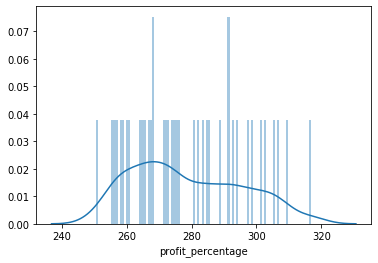

In [22]:
        
paper_result = paper_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
paper_result.to_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))

sns.distplot(paper_result['profit_percentage'],
             bins=100,
             label="Papertest Results")
print(stats.describe(paper_result.profit_percentage))

paper_result.head()



## Plotting Optimized Results

Plot the algo-trading results.


importing Jupyter notebook from strategy_sv.ipynb
Plotting 288 results for trade days
CLOSE 2018-07-20
LONG 2018-07-20 - 2018-07-23
SHORT 2018-07-23 - 2018-07-24
LONG 2018-07-24 - 2018-07-26
SHORT 2018-07-26 - 2018-07-27
CLOSE 2018-07-29
LONG 2018-07-29 - 2018-07-30
SHORT 2018-07-30 - 2018-08-03
LONG 2018-08-03 - 2018-08-06
SHORT 2018-08-06 - 2018-08-07
LONG 2018-08-07 - 2018-08-09
SHORT 2018-08-09 - 2018-08-12
CLOSE 2018-08-13
LONG 2018-08-13 - 2018-08-14
SHORT 2018-08-14 - 2018-08-15
LONG 2018-08-15 - 2018-08-22
SHORT 2018-08-22 - 2018-08-24
LONG 2018-08-24 - 2018-08-28
SHORT 2018-08-28 - 2018-09-02
CLOSE 2018-09-03
LONG 2018-09-03 - 2018-09-04
SHORT 2018-09-04 - 2018-09-05
LONG 2018-09-05 - 2018-09-07
SHORT 2018-09-07 - 2018-09-09
CLOSE 2018-09-10
LONG 2018-09-10 - 2018-09-14
SHORT 2018-09-14 - 2018-09-17
LONG 2018-09-17 - 2018-09-23
SHORT 2018-09-23 - 2018-09-25
LONG 2018-09-25 - 2018-09-26
SHORT 2018-09-26 - 2018-09-28
LONG 2018-09-28 - 2018-10-01
SHORT 2018-10-01 - 2018-10-04
CLO

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


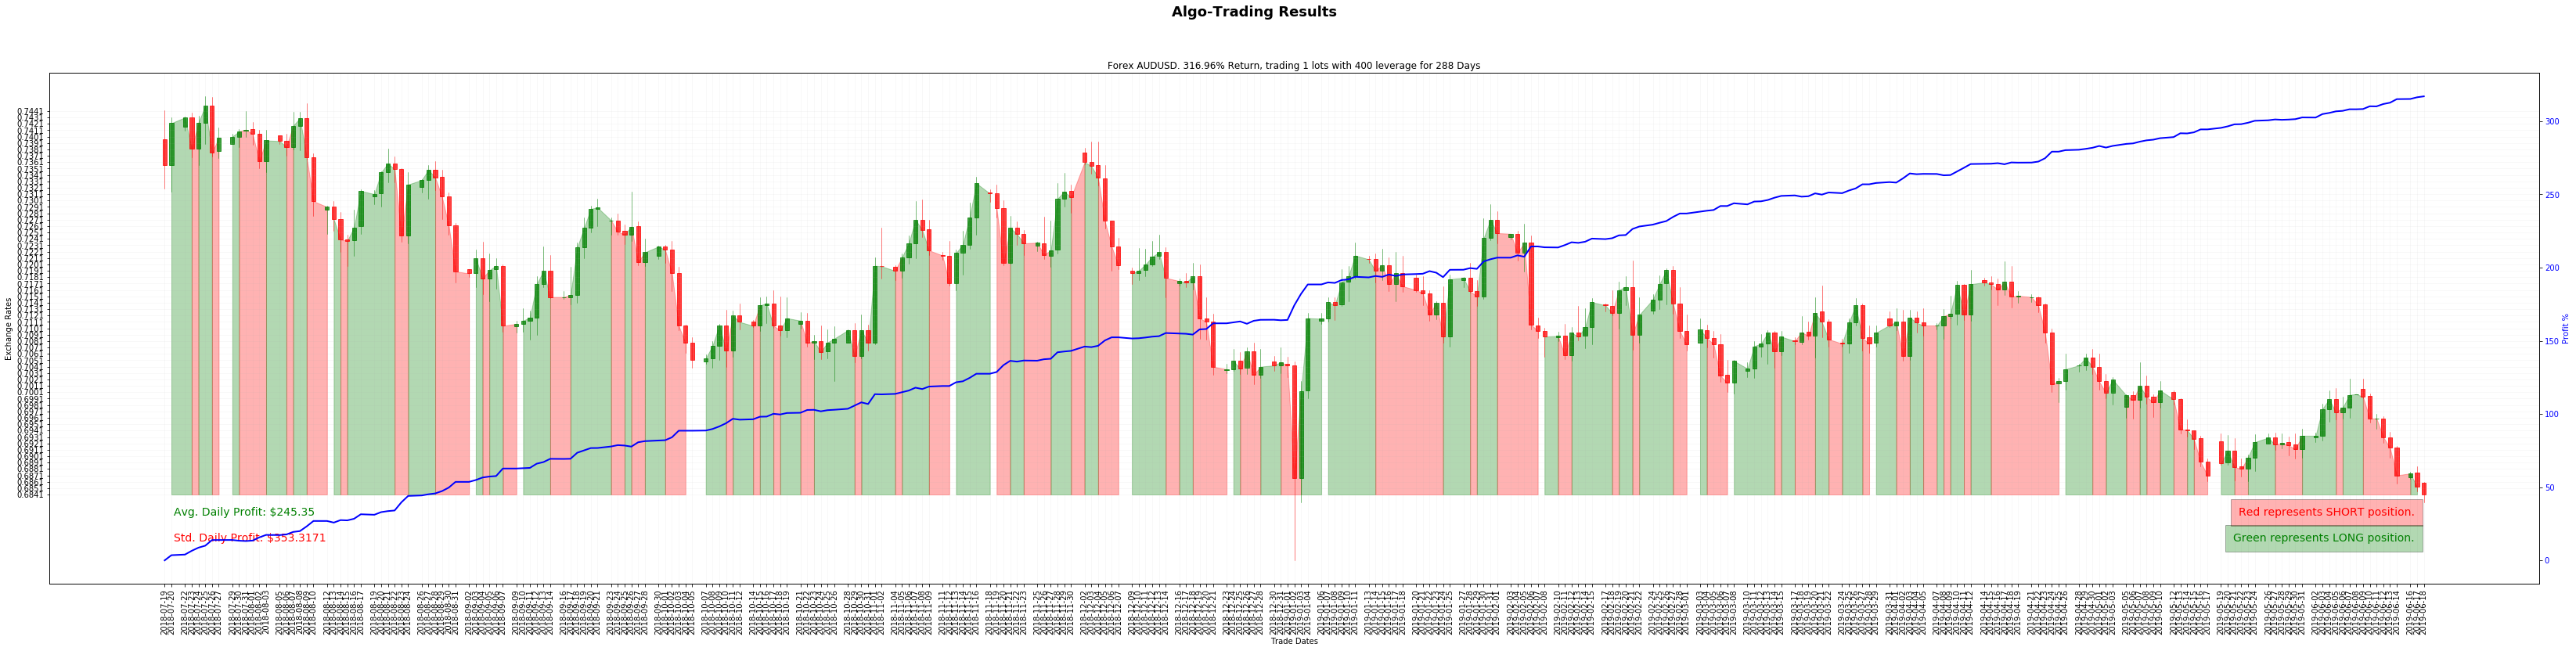

In [24]:

import import_ipynb
from strategy_sv import TradeStrategySV

paper_result = pd.read_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))

fig, axs = plt.subplots(figsize = (int(len(paper_df.index)/5),12))

fig.suptitle('Algo-Trading Results', fontsize=18, fontweight='bold')

best_strategy = TradeStrategySV(leverage=leverage,
                               margin=margin_interest,
                               pip_cost=pip_cost,
                               buy_slope_threshold=paper_result.buy_slope_threshold[1], 
                               buy_velocity_threshold=paper_result.buy_velocity_threshold[1], 
                               close_slope_threshold=paper_result.close_slope_threshold[1], 
                               close_velocity_threshold=paper_result.close_velocity_threshold[1], 
                               sell_slope_threshold=paper_result.sell_slope_threshold[1], 
                               sell_velocity_threshold=paper_result.sell_velocity_threshold[1], 
                               should_log=True)
forex_df = best_strategy.trade(data_df=paper_df, 
                              symbol=forex_symbol,
                              lots=lots,
                              stop_loss=stop_loss,)



best_strategy.plot_trade(axs=axs)

fig.savefig('../gen/StrategySV_{}_Daily.png'.format(forex_symbol), dpi=150, bbox_inches="tight")

print("In the latest {} trading days, StrategySV (Optimized) resulted ${}, or {}%".format(len(paper_df.index), round(best_strategy.trade_profit, 2), round(best_strategy.trade_profit/(lots * 100000 / leverage), 2)))
